## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

## Prepare data

In [2]:
with open("../input/customer-churn-rate-preprocess-data/Churn_Risk_Rate_Dataset.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

del processed_data
gc.collect()

20

In [3]:
train_df['churn_risk_score'] = train_df['churn_risk_score'].apply(lambda x: 0 if x==5 else 1 if x==-1 else x)
train_df.groupby(['churn_risk_score']).size().reset_index().rename(columns={0:'count'})

,churn_risk_score,count
0,0,9825
1,1,3815
2,2,2741
3,3,10422
4,4,10184


In [4]:
ds = np.load('../input/customer-churn-rate-lgb/LGB_Meta_Features.npz', allow_pickle=True)
y_pred_meta_lgb, oof_score_lgb, y_pred_final_lgb = ds['y_pred_meta_lgb'], ds['oof_score'], ds['y_pred_final_lgb']

ds = np.load('../input/customer-churn-rate-xgb/XGB_Meta_Features.npz', allow_pickle=True)
y_pred_meta_xgb, oof_score_xgb, y_pred_final_xgb = ds['y_pred_meta_xgb'], ds['oof_score'], ds['y_pred_final_xgb']

ds = np.load('../input/customer-churn-rate-dnn-v2/DNN_Meta_Features.npz', allow_pickle=True)
y_pred_meta_dnn2, oof_score_dnn2, y_pred_final_dnn2 = ds['y_pred_meta_dnn'], ds['oof_score'], ds['y_pred_final_dnn']

ds = np.load('../input/customer-churn-rate-cb/CB_Meta_Features.npz', allow_pickle=True)
y_pred_meta_cb, oof_score_cb, y_pred_final_cb = ds['y_pred_meta_cb'], ds['oof_score'], ds['y_pred_final_cb']

ds = np.load('../input/customer-churn-rate-dnn/DNN_Meta_Features.npz', allow_pickle=True)
y_pred_meta_dnn1, oof_score_dnn1, y_pred_final_dnn1 = ds['y_pred_meta_dnn'], ds['oof_score'], ds['y_pred_final_dnn']

ds = np.load('../input/customer-churn-rate-cnn-blend/CNN_Meta_Features.npz', allow_pickle=True)
y_pred_meta_cnn, oof_score_cnn, y_pred_final_cnn = ds['y_pred_meta_cnn'], ds['oof_score'], ds['y_pred_final_cnn']

In [5]:
Xtrain_meta = np.concatenate((y_pred_meta_cb, y_pred_meta_lgb, y_pred_meta_xgb, 
                              y_pred_meta_dnn1, y_pred_meta_dnn2, y_pred_meta_cnn), 
                             axis=1)
Ytrain_meta = train_df['churn_risk_score'].values
Xtest_meta = np.concatenate((y_pred_final_cb, y_pred_final_lgb, y_pred_final_xgb, 
                             y_pred_final_dnn1, y_pred_final_dnn2, y_pred_final_cnn), 
                            axis=1)

print("Xtrain_meta shape: {}".format(Xtrain_meta.shape))
print("Ytrain_meta shape: {}".format(Ytrain_meta.shape))
print("Xtest_meta shape: {}".format(Xtest_meta.shape))

Xtrain_meta shape: (36987, 30)
Ytrain_meta shape: (36987,)
Xtest_meta shape: (19919, 30)


In [6]:
temp_df = train_df.groupby(['churn_risk_score']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['churn_risk_score', 'class_weight']].to_dict()['class_weight']
class_weight

{0: 0.2789821882951654,
 1: 0.7184796854521627,
 2: 1.0,
 3: 0.26300134331222413,
 4: 0.2691476826394344}

## Base Models Performance

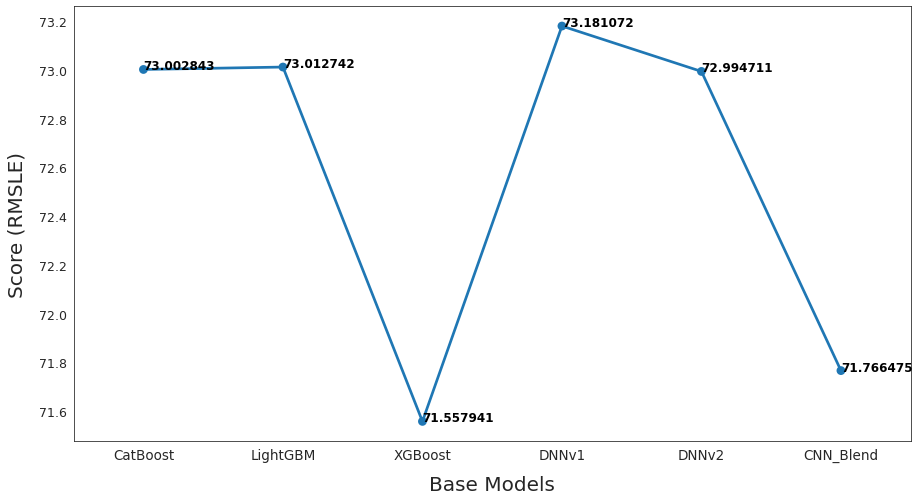

In [7]:
scores={
    'CatBoost': float(oof_score_cb),
    'LightGBM': float(oof_score_lgb),
    'XGBoost': float(oof_score_xgb),
    'DNNv1': float(oof_score_dnn1),
    'DNNv2': float(oof_score_dnn2),
    'CNN_Blend': float(oof_score_cnn)
}

sns.set_style("white")
fig = plt.figure(figsize=(15, 8))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score in list(scores.values())], markers=['o'], linestyles=['-'])
for i, score in enumerate(list(scores.values())):
    ax.text(i, score, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSLE)', size=20, labelpad=12.5)
plt.xlabel('Base Models', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)
plt.show()

## Logistic Regression

In [8]:
FOLD = 7
NUM_SEED = 5

np.random.seed(3)
seeds = np.random.randint(0, 100, size=NUM_SEED)

oof_score = 0
y_pred_meta_lr = np.zeros((Ytrain_meta.shape[0], 5))
y_pred_final_lr = np.zeros((Xtest_meta.shape[0], 5))
counter = 0


for sidx, seed in enumerate(seeds):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain_meta, Ytrain_meta)):
        counter += 1

        train_x, train_y = Xtrain_meta[train], Ytrain_meta[train]
        val_x, val_y = Xtrain_meta[val], Ytrain_meta[val]

        model = LogisticRegression(
            max_iter=1000,
            class_weight=class_weight, 
            random_state=0
        )

        model.fit(train_x, train_y)

        y_pred = model.predict(val_x)
        y_pred_meta_lr[val] += model.predict_proba(val_x)
        y_pred_final_lr += model.predict_proba(Xtest_meta)
        
        score = 100 * f1_score(val_y, y_pred, average='macro')
        oof_score += score
        seed_score += score
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_lr = y_pred_meta_lr / float(NUM_SEED)
y_pred_final_lr = y_pred_final_lr / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Seed-24 | Fold-0 | OOF Score: 73.11467336347323
Seed-24 | Fold-1 | OOF Score: 72.68421131068878
Seed-24 | Fold-2 | OOF Score: 72.72382578079196
Seed-24 | Fold-3 | OOF Score: 74.103792296842
Seed-24 | Fold-4 | OOF Score: 73.05891607532676
Seed-24 | Fold-5 | OOF Score: 74.37034676249709
Seed-24 | Fold-6 | OOF Score: 72.22345118906162

Seed: 24 | Aggregate OOF Score: 73.18274525409736


Seed-3 | Fold-0 | OOF Score: 74.44392988405708
Seed-3 | Fold-1 | OOF Score: 73.38373628835406
Seed-3 | Fold-2 | OOF Score: 72.5108564899004
Seed-3 | Fold-3 | OOF Score: 73.32300387402275
Seed-3 | Fold-4 | OOF Score: 71.29549674679076
Seed-3 | Fold-5 | OOF Score: 74.08452737000243
Seed-3 | Fold-6 | OOF Score: 72.47883189661361

Seed: 3 | Aggregate OOF Score: 73.07434036424873


Seed-56 | Fold-0 | OOF Score: 73.30670707196502
Seed-56 | Fold-1 | OOF Score: 73.20044433272524
Seed-56 | Fold-2 | OOF Score: 73.34900539850409
Seed-56 | Fold-3 | OOF Score: 72.01857925409469
Seed-56 | Fold-4 | OOF Score: 73.85674731

In [9]:
np.savez_compressed('./LR_Meta_Features.npz',
                    y_pred_meta_lr=y_pred_meta_lr, 
                    oof_score=oof_score,
                    y_pred_final_lr=y_pred_final_lr)

## KNeighborsClassifier

In [10]:
FOLD = 7
NUM_SEED = 3

np.random.seed(3)
seeds = np.random.randint(0, 100, size=NUM_SEED)

oof_score = 0
y_pred_meta_knc = np.zeros((Ytrain_meta.shape[0], 5))
y_pred_final_knc = np.zeros((Xtest_meta.shape[0], 5))
counter = 0


for sidx, seed in enumerate(seeds):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain_meta, Ytrain_meta)):
        counter += 1

        train_x, train_y = Xtrain_meta[train], Ytrain_meta[train]
        val_x, val_y = Xtrain_meta[val], Ytrain_meta[val]

        model = KNeighborsClassifier(
            n_neighbors=100
        )

        model.fit(train_x, train_y)

        y_pred = model.predict(val_x)
        y_pred_meta_knc[val] += model.predict_proba(val_x)
        y_pred_final_knc += model.predict_proba(Xtest_meta)
        
        score = 100 * f1_score(val_y, y_pred, average='macro')
        oof_score += score
        seed_score += score
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_knc = y_pred_meta_knc / float(NUM_SEED)
y_pred_final_knc = y_pred_final_knc / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Seed-24 | Fold-0 | OOF Score: 73.32638308660131
Seed-24 | Fold-1 | OOF Score: 74.28782915128544
Seed-24 | Fold-2 | OOF Score: 74.03498824689862
Seed-24 | Fold-3 | OOF Score: 73.92761022603372
Seed-24 | Fold-4 | OOF Score: 74.50552831747375
Seed-24 | Fold-5 | OOF Score: 74.87741653312462
Seed-24 | Fold-6 | OOF Score: 73.46396078726539

Seed: 24 | Aggregate OOF Score: 74.0605309069547


Seed-3 | Fold-0 | OOF Score: 75.35414639328881
Seed-3 | Fold-1 | OOF Score: 74.1581036490507
Seed-3 | Fold-2 | OOF Score: 72.99512642301009
Seed-3 | Fold-3 | OOF Score: 73.60598606996727
Seed-3 | Fold-4 | OOF Score: 73.59095351005423
Seed-3 | Fold-5 | OOF Score: 74.29743863374873
Seed-3 | Fold-6 | OOF Score: 73.07953489964687

Seed: 3 | Aggregate OOF Score: 73.86875565410955


Seed-56 | Fold-0 | OOF Score: 74.03552843033874
Seed-56 | Fold-1 | OOF Score: 73.30800038458742
Seed-56 | Fold-2 | OOF Score: 73.8012241976566
Seed-56 | Fold-3 | OOF Score: 72.7554168129377
Seed-56 | Fold-4 | OOF Score: 74.875874396

In [11]:
np.savez_compressed('./KNC_Meta_Features.npz',
                    y_pred_meta_knc=y_pred_meta_knc, 
                    oof_score=oof_score,
                    y_pred_final_knc=y_pred_final_knc)

## GradientBoostingClassifier

In [12]:
FOLD = 7
NUM_SEED = 3

np.random.seed(3)
seeds = np.random.randint(0, 100, size=NUM_SEED)

oof_score = 0
y_pred_meta_gbc = np.zeros((Ytrain_meta.shape[0], 5))
y_pred_final_gbc = np.zeros((Xtest_meta.shape[0], 5))
counter = 0


for sidx, seed in enumerate(seeds):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain_meta, Ytrain_meta)):
        counter += 1

        train_x, train_y = Xtrain_meta[train], Ytrain_meta[train]
        val_x, val_y = Xtrain_meta[val], Ytrain_meta[val]

        model = GradientBoostingClassifier(
            n_estimators=6000,
            learning_rate=0.07,
            max_depth=8,
            max_leaf_nodes=225,
            n_iter_no_change=100,
            random_state=0
        )

        model.fit(train_x, train_y)

        y_pred = model.predict(val_x)
        y_pred_meta_gbc[val] += model.predict_proba(val_x)
        y_pred_final_gbc += model.predict_proba(Xtest_meta)
        
        score = 100 * f1_score(val_y, y_pred, average='macro')
        oof_score += score
        seed_score += score
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_gbc = y_pred_meta_gbc / float(NUM_SEED)
y_pred_final_gbc = y_pred_final_gbc / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Seed-24 | Fold-0 | OOF Score: 72.90416147847758
Seed-24 | Fold-1 | OOF Score: 74.13185113461041
Seed-24 | Fold-2 | OOF Score: 74.23734057195357
Seed-24 | Fold-3 | OOF Score: 72.78612258096382
Seed-24 | Fold-4 | OOF Score: 73.82670482444797
Seed-24 | Fold-5 | OOF Score: 72.55301582108844
Seed-24 | Fold-6 | OOF Score: 72.92535059275782

Seed: 24 | Aggregate OOF Score: 73.33779242918567


Seed-3 | Fold-0 | OOF Score: 73.75309709973558
Seed-3 | Fold-1 | OOF Score: 73.37061617511078
Seed-3 | Fold-2 | OOF Score: 72.49340617576419
Seed-3 | Fold-3 | OOF Score: 73.49697557139
Seed-3 | Fold-4 | OOF Score: 72.1079196230112
Seed-3 | Fold-5 | OOF Score: 73.46196732000398
Seed-3 | Fold-6 | OOF Score: 72.45750171908263

Seed: 3 | Aggregate OOF Score: 73.02021195487119


Seed-56 | Fold-0 | OOF Score: 73.72105554636886
Seed-56 | Fold-1 | OOF Score: 72.9627833967663
Seed-56 | Fold-2 | OOF Score: 73.26881814569204
Seed-56 | Fold-3 | OOF Score: 72.36105572919105
Seed-56 | Fold-4 | OOF Score: 73.4797805306

In [13]:
np.savez_compressed('./GBC_Meta_Features.npz',
                    y_pred_meta_gbc=y_pred_meta_gbc, 
                    oof_score=oof_score,
                    y_pred_final_gbc=y_pred_final_gbc)

## Voting Classifier

In [14]:
FOLD = 7
NUM_SEED = 3

np.random.seed(3)
seeds = np.random.randint(0, 100, size=NUM_SEED)

oof_score = 0
y_pred_meta_vc = np.zeros((Ytrain_meta.shape[0], 5))
y_pred_final_vc = np.zeros((Xtest_meta.shape[0], 5))
counter = 0


for sidx, seed in enumerate(seeds):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain_meta, Ytrain_meta)):
        counter += 1

        train_x, train_y = Xtrain_meta[train], Ytrain_meta[train]
        val_x, val_y = Xtrain_meta[val], Ytrain_meta[val]

        m1 = LogisticRegression(
            max_iter=1000,
            class_weight=class_weight, 
            random_state=0
        )
        m2 = KNeighborsClassifier(
            n_neighbors=100
        )
        m3 = GradientBoostingClassifier(
            n_estimators=6000,
            learning_rate=0.07,
            max_depth=8,
            max_leaf_nodes=225,
            n_iter_no_change=100,
            random_state=0
        )

        model = VotingClassifier([('lr', m1), ('knc', m2), ('gbc', m3)],
                                 voting='soft')

        model.fit(train_x, train_y)

        y_pred = model.predict(val_x)
        y_pred_meta_vc[val] += model.predict_proba(val_x)
        y_pred_final_vc += model.predict_proba(Xtest_meta)
        
        score = 100 * f1_score(val_y, y_pred, average='macro')
        oof_score += score
        seed_score += score
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_vc = y_pred_meta_vc / float(NUM_SEED)
y_pred_final_vc = y_pred_final_vc / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

Seed-24 | Fold-0 | OOF Score: 73.55861636080093
Seed-24 | Fold-1 | OOF Score: 74.30801812427373
Seed-24 | Fold-2 | OOF Score: 74.2368791497293
Seed-24 | Fold-3 | OOF Score: 73.60859993416616
Seed-24 | Fold-4 | OOF Score: 74.70954327957699
Seed-24 | Fold-5 | OOF Score: 74.09825465882751
Seed-24 | Fold-6 | OOF Score: 73.21845800701132

Seed: 24 | Aggregate OOF Score: 73.96262421634086


Seed-3 | Fold-0 | OOF Score: 74.63462571957787
Seed-3 | Fold-1 | OOF Score: 74.04838279728395
Seed-3 | Fold-2 | OOF Score: 73.10190338144936
Seed-3 | Fold-3 | OOF Score: 73.61815717896974
Seed-3 | Fold-4 | OOF Score: 72.98369267903502
Seed-3 | Fold-5 | OOF Score: 73.7814085820426
Seed-3 | Fold-6 | OOF Score: 73.16420344415711

Seed: 3 | Aggregate OOF Score: 73.61891054035938


Seed-56 | Fold-0 | OOF Score: 73.74735208215951
Seed-56 | Fold-1 | OOF Score: 73.40541750240897
Seed-56 | Fold-2 | OOF Score: 73.94585836091471
Seed-56 | Fold-3 | OOF Score: 73.23047725827657
Seed-56 | Fold-4 | OOF Score: 74.4717631

In [15]:
np.savez_compressed('./VC_Meta_Features.npz',
                    y_pred_meta_vc=y_pred_meta_vc, 
                    oof_score=oof_score,
                    y_pred_final_vc=y_pred_final_vc)

## Create submission file

In [16]:
test_df = pd.read_csv("../input/customer-churn-rate-prediction/dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['customer_id'] = test_df['customer_id']

In [17]:
submit_df['churn_risk_score'] = np.array([np.argmax(y_pred_final_lr, axis=1)]).T
submit_df['churn_risk_score'] = submit_df['churn_risk_score'].apply(lambda x: 5 if x==0 else x)
submit_df.to_csv("./LR_submission.csv", index=False)
submit_df.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [18]:
submit_df['churn_risk_score'] = np.array([np.argmax(y_pred_final_knc, axis=1)]).T
submit_df['churn_risk_score'] = submit_df['churn_risk_score'].apply(lambda x: 5 if x==0 else x)
submit_df.to_csv("./KNC_submission.csv", index=False)
submit_df.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [19]:
submit_df['churn_risk_score'] = np.array([np.argmax(y_pred_final_gbc, axis=1)]).T
submit_df['churn_risk_score'] = submit_df['churn_risk_score'].apply(lambda x: 5 if x==0 else x)
submit_df.to_csv("./GBC_submission.csv", index=False)
submit_df.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [20]:
submit_df['churn_risk_score'] = np.array([np.argmax(y_pred_final_vc, axis=1)]).T
submit_df['churn_risk_score'] = submit_df['churn_risk_score'].apply(lambda x: 5 if x==0 else x)
submit_df.to_csv("./VC_submission.csv", index=False)
submit_df.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [21]:
y_pred_final = (y_pred_final_lr * 0.1) + \
               (y_pred_final_knc * 0.4) + \
               (y_pred_final_gbc * 0.25) + \
               (y_pred_final_vc * 0.25)

submit_df['churn_risk_score'] = np.array([np.argmax(y_pred_final, axis=1)]).T
submit_df['churn_risk_score'] = submit_df['churn_risk_score'].apply(lambda x: 5 if x==0 else x)
submit_df.to_csv("./BLEND_submission.csv", index=False)
submit_df.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5
